# IMPORTING LIBRARIES AND MODULES

In [1]:
import timm # PyTorch Image Models
import os 
import pandas as pd
import torch
import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOADING DATA DIRECTORY
data_dir = "/home/phongtnh/Pet Breed Dataset"

In [3]:
# extract all classes from dataset
def extract_classes(dir):
    """
    Extract label from directory
    e.g: Abyssinian_1.jpg -> Abyssinian
    """
    classes = set()
    for file in os.listdir(dir):
        classes.add(file.split('_')[0])
    
    return classes
print(list(extract_classes('/home/phongtnh/Pet Breed Dataset/Pet Breed')))
print(len(list(extract_classes('/home/phongtnh/Pet Breed Dataset/Pet Breed'))))
BREED_CLASSES = list(extract_classes('/home/phongtnh/Pet Breed Dataset/Pet Breed'))
print(len(BREED_CLASSES))

['japanese', 'pomeranian', 'basset', 'scottish', 'Bombay', 'yorkshire', 'saint', 'Egyptian', 'Birman', 'chihuahua', 'havanese', 'Sphynx', 'american', 'samoyed', 'Ragdoll', 'miniature', 'pug', 'boxer', 'beagle', 'keeshond', 'Siamese', 'staffordshire', 'Persian', 'Abyssinian', 'British', 'shiba', 'english', 'newfoundland', 'leonberger', 'german', 'Bengal', 'Russian', 'great', 'Maine', 'wheaten']
35
35


In [4]:
# encode labels
def encode_label(img_path):
    label = img_path.split('_')[0]
    target = torch.zeros(len(BREED_CLASSES))
    target[BREED_CLASSES.index(label)] = 1
    return target
# test encode labels
encode_label('beagle_1.jpg')

def decode_labels(target):
    return BREED_CLASSES[target.argmax()]
#test decode labels
temp = torch.zeros(len(BREED_CLASSES))
temp[34] = 1
print(decode_labels(temp))

def load_image(img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    return img


wheaten


In [5]:
pd_train = pd.read_csv('/home/phongtnh/Pet Breed Dataset/annotations/trainval.txt', sep=' ', header=None)[0]
pd_test = pd.read_csv('/home/phongtnh/Pet Breed Dataset/annotations/test.txt', sep=' ', header=None)[0]
print("Train:", len(pd_train))
print("Test:", len(pd_test))

Train: 3680
Test: 3669


In [6]:
# Dataset 
from torchvision.io import read_image
#Create Custom dataset class for Pascal_2007
class PetBreed(Dataset):
    def __init__(self, transform=None, is_train = False, is_test = False):
        if is_train:
            self.path = pd.read_csv('/home/phongtnh/Pet Breed Dataset/annotations/trainval.txt', sep=' ', header=None)[0]
        if is_test:
            self.path = pd.read_csv('/home/phongtnh/Pet Breed Dataset/annotations/test.txt', sep=' ', header=None)[0]

        self.transform = transform

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        img_path = '/home/phongtnh/Pet Breed Dataset/Pet Breed/' + self.path[idx] + '.jpg' #/home/phongtnh/Pet Breed Dataset/Pet Breed/Abyssinian_1.jpg
        image = load_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, encode_label(self.path[idx])

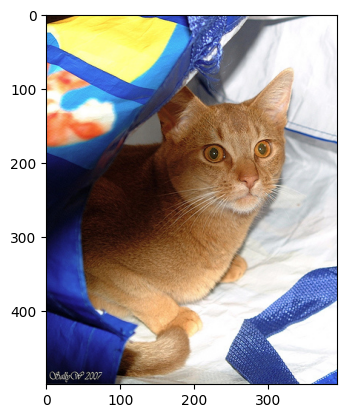

In [7]:
img = load_image("/home/phongtnh/Pet Breed Dataset/Pet Breed/Abyssinian_100.jpg")
plt.imshow(img)

In [8]:
temp = PetBreed(is_train=True)
print(temp[0][0].size)

(394, 500)


In [9]:
# CONVERT TO LIGHTNING DATA MODULE
class PetBreedLN(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        # Mean and Std by ImageNet
        MEAN =[0.457342265910642, 0.4387686270106377, 0.4073427106250871]
        STD =[0.26753769276329037, 0.2638145880487105, 0.2776826934044154]  

        # train transforms
        self.train_transform = T.Compose([
            T.Resize((300, 300)),
            T.RandomChoice([
                                T.ColorJitter(brightness=(0.9, 1.1)),
                                T.RandomGrayscale(p = 0.25)
                                ]),
            T.RandomHorizontalFlip(p = 0.25),
            T.RandomRotation(25),
            T.ToTensor(),
            T.Normalize(mean = MEAN, std = STD),
            ])
        # test transforms
        self.eval_transform = T.Compose([
            T.Resize((300, 300)),
            T.ToTensor(),
            T.Normalize(mean = MEAN, std = STD)
            ])
        
        
    def setup(self):
        self.train_data = PetBreed(transform=self.train_transform, is_train=True)
        self.test_data = PetBreed(transform=self.eval_transform, is_test=True)
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=32, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.test_data, batch_size=32, num_workers=4) 
    
PetBreedData = PetBreedLN()
PetBreedData.setup()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

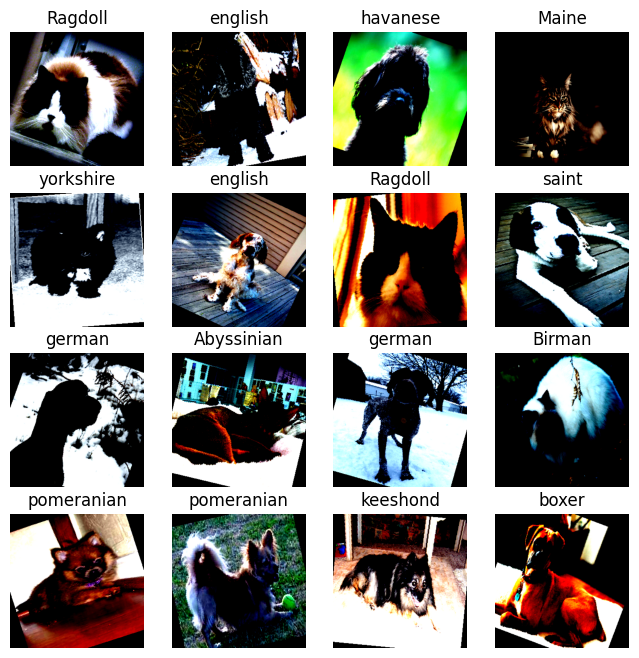

In [10]:
# Visualize the image of the PetBreedData

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(PetBreedData.train_data), size=(1,)).item()
    img, label = PetBreedData.train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    title = f"{decode_labels(label)}" 
    plt.title(title) 
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

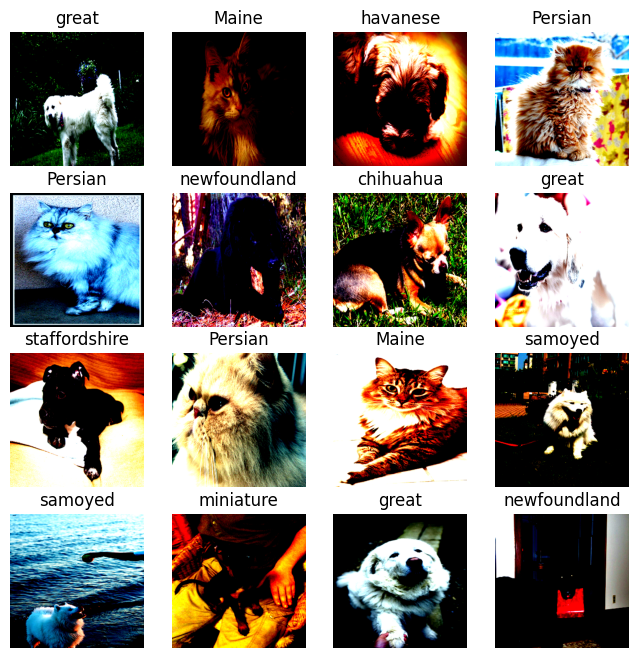

In [11]:
# Visualize the image of the PetBreedData

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(PetBreedData.test_data), size=(1,)).item()
    img, label = PetBreedData.test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    title = f"{decode_labels(label)}" 
    plt.title(title) 
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
plt.show()



In [12]:
# MODEL
from typing import Any
from pytorch_lightning.utilities.types import STEP_OUTPUT
import timm
from torchmetrics.classification import Accuracy
from lightning.pytorch.loggers import TensorBoardLogger

model = timm.create_model('resnet18', pretrained=True, num_classes=len(BREED_CLASSES))

# PyTorch Lightning Module
class Resnet18(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=len(BREED_CLASSES))

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        return optimizer
    
    def _calculate(self, batch):
        input, target = batch
        output = self.model(input)
        loss = self.criterion(output, target)
        
        # convert all outputs to onehot form
        pred = torch.argmax(output, dim=1)
        target = torch.argmax(target, dim=1)
        
        acc = self.accuracy(pred, target)
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self._calculate(batch)
        return {
            'loss': loss,
            'acc': acc
        }
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self._calculate(batch)
        return {
            'loss': loss,
            'acc': acc
        }

In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.utils import make_grid

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='inferno')

class ResnetCallback(Callback):
    def __init__(self, load_trained = False):
        super().__init__()
        self.train_outputs = []
        self.val_outputs = []
        self.load_trained = load_trained

    def on_fit_start(self, trainer, pl_module):
        if self.load_trained:
            if os.path.exists('/home/phongtnh/PIXTA_TRAINING/model_15.pth'):
                # load pretrained model from pytorch checkpoint
                checkpoint = torch.load('/home/phongtnh/PIXTA_TRAINING/model_15.pth')['model_state_dict']
                model_dict = pl_module.state_dict()
                pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
                model_dict.update(pretrained_dict)
                pl_module.load_state_dict(model_dict)
            else:
                print('No pretrained model found')
        else:
            print('Training from scratch')

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused = 0):
        self.train_outputs.append(outputs)
        
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused=0):
        self.val_outputs.append(outputs)

    def on_train_epoch_end(self, trainer, pl_module):
        avg_loss = torch.stack([x['loss'] for x in self.train_outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in self.train_outputs]).mean()
        
        pl_module.logger.experiment.add_scalar("Loss/train",
                                          avg_loss,
                                          pl_module.current_epoch)
        
        pl_module.logger.experiment.add_scalar("Accuracy/train",
                                          avg_acc,
                                          pl_module.current_epoch)
        
    def on_validation_epoch_end(self, trainer, pl_module):
        avg_loss = torch.stack([x['loss'] for x in self.val_outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in self.val_outputs]).mean()
        self.log('val_loss', avg_loss)
        
        pl_module.logger.experiment.add_scalar("Loss/val",
                                            avg_loss,
                                            pl_module.current_epoch)
        pl_module.logger.experiment.add_scalar("Accuracy/val",
                                            avg_acc,
                                            pl_module.current_epoch)
        # Output epoch number, loss, acc
        print('Epoch: {}, Loss: {}, Accuracy: {}'.format(pl_module.current_epoch, avg_loss, avg_acc))
        
    def on_fit_end(self, trainer, pl_module):
        filter = pl_module.model.state_dict()['conv1.weight'].data.clone()
        visTensor(filter, ch=0, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()
        

              

In [18]:
Resnet = Resnet18(model)
logger = TensorBoardLogger('runs', name="Resnet18_Lightning")
trainer = pl.Trainer(accelerator='gpu',
                     max_epochs=20,
                     devices=[3],
                     logger=logger,
                     num_sanity_val_steps=1,
                     callbacks=[ResnetCallback(load_trained=False)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.778    Total estimated model params size (MB)


Training from scratch


Sanity Checking: 0it [00:00, ?it/s]

Epoch: 0, Loss: 3.442699670791626, Accuracy: 0.03125


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch: 0, Loss: 1.6519944667816162, Accuracy: 0.7233169078826904


Validation: 0it [00:00, ?it/s]

Epoch: 1, Loss: 1.2108198404312134, Accuracy: 0.7794784307479858


Validation: 0it [00:00, ?it/s]

Epoch: 2, Loss: 0.9732186198234558, Accuracy: 0.8114936351776123


Validation: 0it [00:00, ?it/s]

Epoch: 3, Loss: 0.8422124981880188, Accuracy: 0.8257056474685669


Validation: 0it [00:00, ?it/s]

Epoch: 4, Loss: 0.7531196475028992, Accuracy: 0.8380947113037109


Validation: 0it [00:00, ?it/s]

Epoch: 5, Loss: 0.6926270723342896, Accuracy: 0.8459530472755432


Validation: 0it [00:00, ?it/s]

Epoch: 6, Loss: 0.6537562012672424, Accuracy: 0.8501344323158264


Validation: 0it [00:00, ?it/s]

Epoch: 7, Loss: 0.6185217499732971, Accuracy: 0.8551200032234192


Validation: 0it [00:00, ?it/s]

Epoch: 8, Loss: 0.5872875452041626, Accuracy: 0.8593160510063171


Validation: 0it [00:00, ?it/s]

Epoch: 9, Loss: 0.5614100694656372, Accuracy: 0.863108217716217


Validation: 0it [00:00, ?it/s]

Epoch: 10, Loss: 0.5409733057022095, Accuracy: 0.8660514950752258


Validation: 0it [00:00, ?it/s]

Epoch: 11, Loss: 0.5267136096954346, Accuracy: 0.8673838973045349


Validation: 0it [00:00, ?it/s]

Epoch: 12, Loss: 0.5120568871498108, Accuracy: 0.8702035546302795


Validation: 0it [00:00, ?it/s]

Epoch: 13, Loss: 0.4996320605278015, Accuracy: 0.8722520470619202


Validation: 0it [00:00, ?it/s]

Epoch: 14, Loss: 0.489261269569397, Accuracy: 0.8738101720809937


Validation: 0it [00:00, ?it/s]

Epoch: 15, Loss: 0.48094695806503296, Accuracy: 0.8749264478683472


Validation: 0it [00:00, ?it/s]

Epoch: 16, Loss: 0.4732556939125061, Accuracy: 0.8763518929481506


Validation: 0it [00:00, ?it/s]

Epoch: 17, Loss: 0.4665922224521637, Accuracy: 0.8773783445358276


Validation: 0it [00:00, ?it/s]

Epoch: 18, Loss: 0.46065741777420044, Accuracy: 0.8783676028251648


Validation: 0it [00:00, ?it/s]

Epoch: 19, Loss: 0.4562482535839081, Accuracy: 0.8790199756622314


`Trainer.fit` stopped: `max_epochs=20` reached.


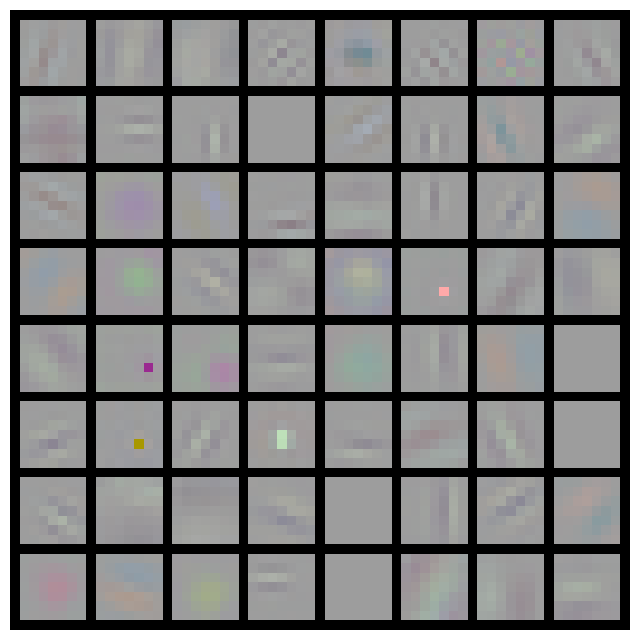

In [19]:
trainer.fit(Resnet, PetBreedData.train_dataloader(), PetBreedData.val_dataloader())